In [10]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

[[ 0.16935795  0.35903928]
 [ 2.08886514  2.71318874]
 [ 2.96511185 -0.03487926]
 ...
 [ 4.47484706  3.37203401]
 [ 5.19610842  4.25667388]
 [ 4.67632026  2.82196607]]


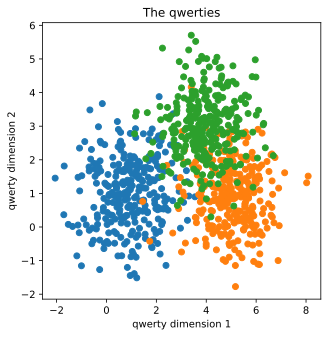

In [11]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur] 
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur] 
c = [ C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]
# true labels 
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1)),np.full((nPerClust,1),2)))

#convert to a pytorch tensor
data_np = np.hstack((a,b,c)).T

print(data_np)

# convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize = (5,5))
plt.scatter(data[np.where(labels==0)[0], 0], data[np.where(labels == 0)[0], 1])
plt.scatter(data[np.where(labels==1)[0], 0], data[np.where(labels == 1)[0], 1])
plt.scatter(data[np.where(labels==2)[0], 0], data[np.where(labels == 2)[0], 1])

plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2)

# then convert them into pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last= True)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [13]:
# create a class for the model 
def createTheQwertyNet(optimizerAlgo):
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer 
            self.input = nn.Linear(2,8)

            # hiddent layer 
            self.fc1 = nn.Linear(8,8)

            # output layer
            self.output = nn.Linear(8,3)

        def forward(self, X):
            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            return self.output(X)
        
    # create the model instance 
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optifun = getattr(torch.optim, optimizerAlgo)
    optimizer = optifun(net.parameters(), lr = .01)

    return net, lossfun, optimizer

In [14]:
optim = createTheQwertyNet('RMSprop')[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [15]:
numepochs = 50

def function2trainTheModel(optimizerType):
    # create a new model
    net, lossfun , optimizer = createTheQwertyNet(optimizerType)
    

    # initialize losses 
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        net.train()

        # looping over training batches 
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss 
            yHat = net(X)
            loss = lossfun(yHat, y)

            # BACKPROP 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy

            matches = torch.argmax(yHat, axis = 1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)

        testAcc.append(100*torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
    
    return trainAcc, testAcc, losses , net

In [19]:
def plotTheResults(optimizerType):

    # compute accuracy over entire dataset
    yHat = net(data)
    predictions = torch.argmax(yHat, axis = 1)
    accuracy = (predictions == labels).float()
    totalAcc = torch.mean(100*accuracy).item()


    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[labels == i])

    
    # create the figure 
    fig, ax = plt.subplots(2,2, figsize = (10,6))

    # plot the loss function 
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('epoch')
    ax[0,0].set_title(f'{optimizerType}: Losses')


    # plot the accuracy function 
    ax[0,1].plot(trainAcc, label = 'Train')
    ax[0,1].plot(testAcc, label = 'Test')
    ax[0,1].set_ylabel('Accuracy')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].legend()
    ax[0,1].set_title(f'{optimizerType}: Accuracy')


    # plot overall accuracy by group 
    ax[1,0].bar(range(3), accuracyByGroup)
    ax[1,0].set_ylim([np.min(accuracyByGroup) - 5, np.max(accuracyByGroup)+5])
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')

    # scatter plot of correct and incorrect labeled data 
    colorShapes = ['bs', 'ko', 'g^']
    for i in range(3):
        ax[1,1].plot(data[labels == i, 0], 
                     data[labels == i, 1], 
                     colorShapes[i], 
                     alpha = .3, 
                     label = f'Group {i}')
        
    # crossout the incorrect ones 
    idxErr = (accuracy == 0) & (labels == i)
    ax[1,1].plot(data[idxErr, 0], data[idxErr, 1], 'rx')
    ax[1,1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
    ax[1,1].set_xlabel('Qwerty Dimension 1')
    ax[1,1].set_ylabel('Qwerty Dimension 2')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()






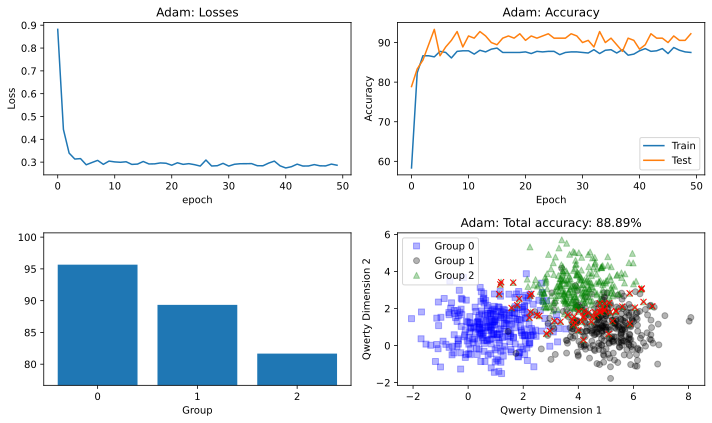

In [20]:
# run the model for one optimizer 
optimizerType = 'Adam'
trainAcc, testAcc, losses, net = function2trainTheModel(optimizerType)

# visualizing 
plotTheResults(optimizerType)

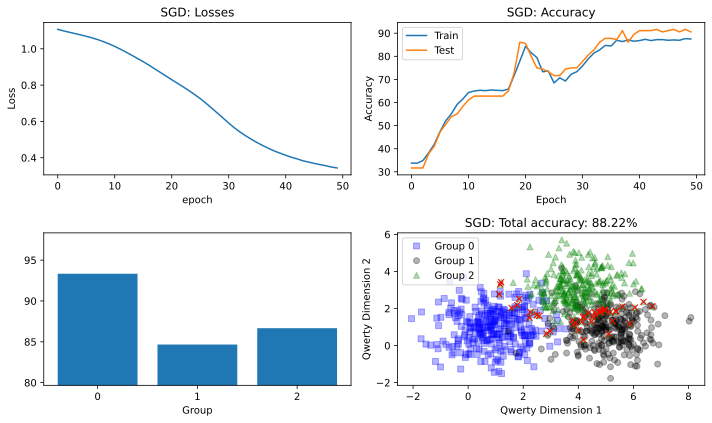

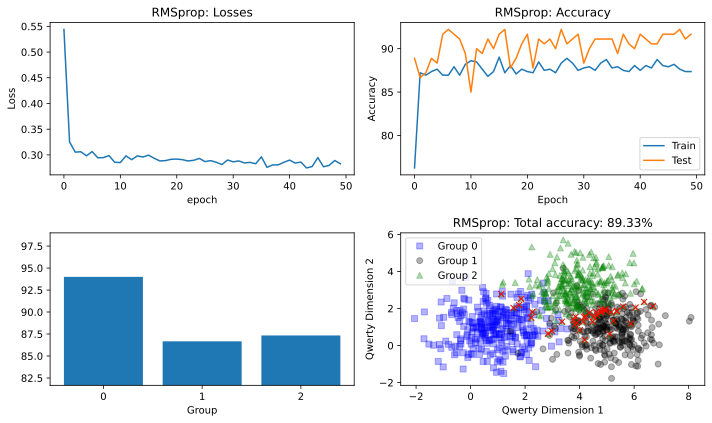

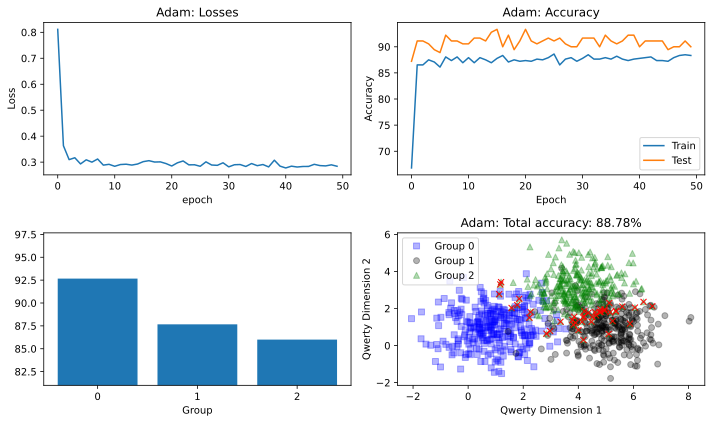

In [22]:
# now run thorugh all of them 
# average performance 
performance = []

for opto in ['SGD', 'RMSprop','Adam']:
    trainAcc, testAcc, losses, net = function2trainTheModel(opto)
    plotTheResults(opto)

    # store the funal results
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])

    performance.append(f'{opto}: train {train:.1f}%, test { test:.1f}%')

In [23]:
performance

['SGD: train 87.2%, test 91.1%',
 'RMSprop: train 87.9%, test 91.4%',
 'Adam: train 87.9%, test 90.5%']